# https://github.com/ShuaiBai623/AI-City-Anomaly-Detection/blob/master/src/detection/perspective_crop.py

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import scipy
import cv2 as cv
import json
import PIL
import re

In [2]:
def load_video(filename):
    # Loads a video with opencv, returns PIL Images for each frame
    
    vid = cv.VideoCapture(filename)

    while vid.isOpened():
        has_frame, img = vid.read()

        if has_frame:
            yield PIL.Image.fromarray(img[:,:,::-1])
        else:
            break
            
    vid.release()
    
def get_video_shape(filename):
    vid = cv.VideoCapture(filename)
    _, img = vid.read()
    vid.release()
    
    return img.shape

In [3]:
def read_json(filename):
    with open(filename) as f:
        return json.load(f)

def write_json(filename, data):
    with open(filename, "w") as f:
        json.dump(data, f)

In [4]:
def parse_json(js):
    """
    json structure:
    {
        frame: {"1": [], "2": [], "3":, "4": [
            [[x1, y1, x2, y2], score],
            ...
        ]},
        ...
    }
    """
    
    
    boxes = []
    for frame in js:
        for bbox, score in js[frame]["4"]:
            if score > 0:
                boxes.append(bbox)
            
    return boxes

In [24]:
def do_regression(df=None, bboxes=None, plot=False):
    """
    Does linear regression of y-position vs vehicle height
    h = a * y + b
    
    df: DataFrame with columns: [y, h, w]. Represents y-position, height, width of bounding boxes
    bboxes: list of bounding boxes [[x1, y1, x2, y2], ...]
    """
    
    if df is not None:
        y = df["y"] + df["h"] / 2 # center y coord of bbox
        h = np.sqrt(df["w"] * df["h"]) # sqrt bbox area
    elif bboxes is not None:
        y = [(y1 + y2) / 2 for x1, y1, x2, y2 in bboxes]
        h = [np.sqrt((x2 - x1) * (y2 - y1)) for x1, y1, x2, y2 in bboxes]
    else:
        raise Exception("Provide one of: df, bboxes")
        
    
    regression = linear_model.LinearRegression()
    
    regression.fit(
        np.array(y).reshape(-1, 1), # (n, 1)
        np.array(h) # (n)
    )
    
    a, b = regression.coef_[0], regression.intercept_
    
    if plot:
        f = lambda x: a * x + b
        # plot points
        plt.plot(y, h, "o", )
        plt.plot([0, max(y)], [f(0), f(max(y))])
        plt.xlabel("y position")
        plt.ylabel("sqrt bounding box area")
        plt.show()
        
        print(f"a: {a}, b: {b}")
    
    
    return a, b

In [6]:
def generate_box_row(y_min, box_height, box_width, img_width, exclude_last=False, clip_last=True):
    """
    Creates bounding boxes for a single row
    
    y_min: base y-coordinate for boxes
    box_height:
    box_width:
    img_width:
    exclude_last: whether or not to create the last box of the row, which usualy overlaps outside the image boundary.
    clip_last: if true, chops the end off the last box of the row. if exclude_last == false, this has no effect.
    
    """
    
    
    num_boxes = int(np.ceil(img_width / box_width))
    x_positions = np.linspace(0, box_width * num_boxes, num_boxes + 1)
    
    if exclude_last: # exclude box that would be partially outside image
        x_positions = x_positions[:-1]
    
    boxes = []
    for x_min, x_max in zip(x_positions[:-1], x_positions[1:]):
        if clip_last and x_max >= img_width: # clip last box to image boundary
            x_max = img_width - 1
        
        boxes.append([int(x_min), y_min, int(x_max), y_min + box_height])
    
    return boxes


def generate_crop_boxes(min_height, a_reg, b_reg, img_shape, row_capacity=3, box_aspect_ratio=2, exclude_last=False, clip_last=True):
    """
    Creates all crop boxes for the image.
    
    min_height: minimum vehicle height
    a_reg: linear regression coefficient for y-pos vs height
    b_reg: linear regression intercept for y-pos vs height
    img_shape: (height, width) of image
    row_capacity: Vehicle capacity for each row. Not 100% sure how to explain this.
    box_aspect_rato: width/height bounding box ratio
    exclude_last, clip_last: see generate_box_row function.
    
    """
    
    
    def exp_func(x):
        # Modified function, seems to work better/properly
        # capacity space -> height space
#         return int(np.exp(x) / a_reg) # theirs
        return int(np.exp(a_reg * x)) # mine
    
    def log_func(x):
        # height space -> capacity space
        return np.log(x) / a_reg
    
    def f(y):
        # h = a * y + b
        # y position -> vehicle height at that position
        return a_reg * y + b_reg
    
    def f_inv(h):
        # vehicle height -> y position
        return int((h - b_reg) / a_reg)
    
    # k * ln(k*y2+b) - k * ln(k*y1+b) this corresponds to the big integral in the paper
    total_capacity = log_func(f(img_shape[0])) - log_func(min_height)
    
    num_rows = int(np.ceil(total_capacity / row_capacity))
    stride_cap = total_capacity / num_rows # capacity stride
    
    start_capacity = log_func(min_height)
    vert_capacities = np.linspace(start_capacity, start_capacity + stride_cap * num_rows, num_rows + 1)
    
    # convert to y coord
#     y_positions = list(map((lambda x: exp_func(a_reg * x - b_reg)), vert_capacities)) # theirs
    y_heights = list(map(exp_func, vert_capacities)) # mine
    y_positions = list(map(f_inv, y_heights))
    
    
    boxes = []
    for y_min, y_max in zip(y_positions[:-1], y_positions[1:]):
        box_width = (y_max - y_min) * box_aspect_ratio
        
        boxes += generate_box_row(y_min, y_max - y_min, box_width, img_shape[1], exclude_last, clip_last)
    
    return boxes

In [7]:
def crop_image(img, crop_boxes):
    """
    img: PIL Image
    crop_boxes: list of boxes [x1, y1, x2, y2]
    """
    
    return [img.crop(box) for box in crop_boxes]

def resize_crops(crops, threshold=0.01):
    """
    Resizes images to the biggest in the list.
    Maintains aspect ratio, pads if necessary.
    
    Uses area to determine biggest image, might not work well if the biggest image is chopped off a bit
    
    """
    
    
    biggest_size = max((img.size for img in crops), key=np.prod)
    biggest_aspect = biggest_size[0] / biggest_size[1]
    
    resized = []
    for img in crops:
        aspect = img.size[0] / img.size[1]
        
        # chopped off image -> scale and pad
        if abs(biggest_aspect - aspect) > threshold: 
            scaled = img.resize((int(biggest_size[0] * aspect / biggest_aspect), biggest_size[1]))
            
            new = PIL.Image.new("RGB", biggest_size, (0,0,0))
            new.paste(scaled, scaled.getbbox())
        
        # normal image -> scale
        else:
            new = img.resize(biggest_size)
            
        resized.append(new)
            
    return resized

In [38]:
def create_crop_boxes(results_path, crop_boxes_path, video_path, min_object_size=10, row_capacity=3, crop_box_aspect_ratio=2):
    # Video info
    img_shape = get_video_shape(video_path)
    
    # Read bboxes
    bboxes = parse_json(read_json(results_path))
    a, b = do_regression(bboxes=bboxes, plot=True)
    
    # maybe use frame by frame boxes instead?
#     bbox_df = pd.read_csv(results_path, header=None, 
#                           names=["frame", "NA", "x", "y", "w", "h", "confidence", "NA", "NA", "NA"])
#     a, b = do_regression(df=bbox_df, plot=True)

    # Create crop boxes
    crop_boxes = generate_crop_boxes(min_object_size, a, b, img_shape, row_capacity, crop_box_aspect_ratio)
    
    # Save crop boxes
    write_json(crop_boxes_path, crop_boxes)

In [39]:
def process_folder(results_folder, crop_boxes_folder, video_folder, min_object_size=10, row_capacity=3, crop_box_aspect_ratio=2):
    for results_filename in sorted(os.listdir(results_folder)):
        match = re.match("^video(\d+)\.json$", results_filename) # video123.json
#         match = re.match("^video(\d+)\.txt$", results_filename) # video123.txt
        if not match:
            continue
            
        video_id = int(match.groups()[0])
        
        results_path = os.path.join(results_folder, f"video{video_id}.json")
#         results_path = os.path.join(results_folder, f"video{video_id}.txt")
        crop_boxes_path = os.path.join(crop_boxes_folder, f"{video_id}.json")
        video_path = os.path.join(video_folder, f"{video_id}.mp4")
        
        print(f"Processing video {video_id}...")
        
        create_crop_boxes(results_path, crop_boxes_path, video_path, min_object_size, row_capacity, crop_box_aspect_ratio)

---

In [31]:
fbf_results_dir = "/data/aicity/winner_team/detection_results/test_framebyframe/"
results_dir = "/data/aicity/winner_team/detection_results/test_static"
crop_boxes_dir = "/data/aicity/winner_team/crop_boxes/test"
video_dir = "/data/aicity/test"

#### Using Frame by Frame Detections

Processing video 2...


/home/adam/.local/share/virtualenvs/data-I7nS9QO2/lib/python3.6/site-packages/pandas/io/parsers.py:702: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


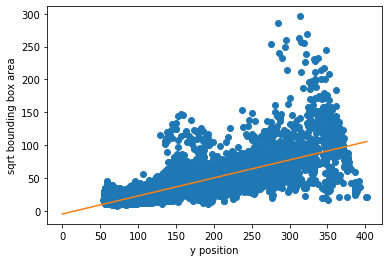

a: 0.27418568329325593, b: -4.8743705432681885


In [36]:

process_folder(fbf_results_dir, crop_boxes_dir, video_dir)

#### Using Static Image detections

Processing video 2...


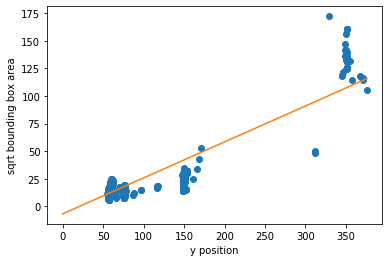

a: 0.3262630221942028, b: -6.893367033315663


In [40]:
process_folder(results_dir, crop_boxes_dir, video_dir)

### Display results

#### Frame by Frame

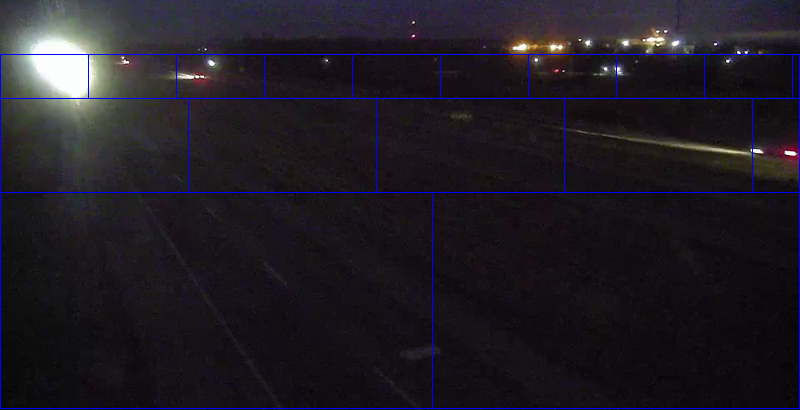

In [37]:
img = next(load_video(os.path.join(video_dir, "2.mp4")))
img_np = np.array(img)
crop_boxes = read_json(os.path.join(crop_boxes_dir, "2.json"))


for x, y, x1, y1 in crop_boxes:
    cv.rectangle(img_np, (int(x), int(y)), (int(x1), int(y1)), (0, 0, 255), 1) # draw boxes
    
PIL.Image.fromarray(img_np)

#### Static

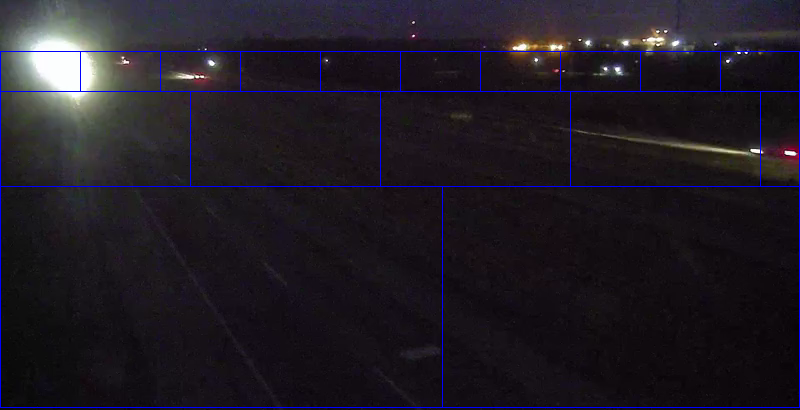

In [41]:
img = next(load_video(os.path.join(video_dir, "2.mp4")))
img_np = np.array(img)
crop_boxes = read_json(os.path.join(crop_boxes_dir, "2.json"))


for x, y, x1, y1 in crop_boxes:
    cv.rectangle(img_np, (int(x), int(y)), (int(x1), int(y1)), (0, 0, 255), 1) # draw boxes
    
PIL.Image.fromarray(img_np)

# Normalising cropped regions

In [22]:
crops = crop_image(img, crop_boxes)
resized = resize_crops(crops)

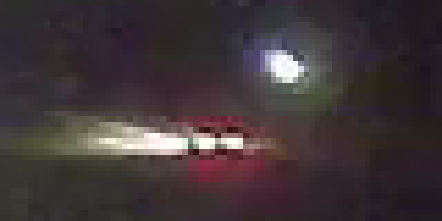

In [26]:
resized[2]

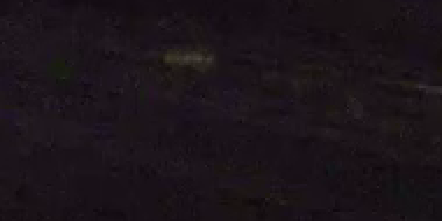

In [24]:
resized[12]

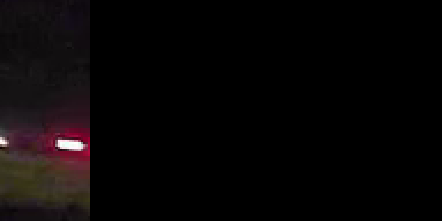

In [27]:
resized[-3]

---
# Pipeline
* run object detection on raw image -> bounding boxes

* take bounding boxes, generate crop boxes
* use crop boxes split raw image, and resize/pad the regions
* run object detection on new regions -> scale bounding boxes back to original image
* repeat crop box generation/detection as much as needed to calibrate

* pass on the calibrated crop boxes & detection results